![](https://quantum-journal.org/wp-content/uploads/2020/10/1912.08278v2.png)

---

In practice, very few people train an entire **Convolutional Network** from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.

Slides and materials: https://cs231n.github.io/transfer-learning/

* **Finetuning the convnet**: Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.

* **ConvNet as fixed feature extractor**: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [3]:
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)

# Torch RNG
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Python RNG
np.random.seed(seed)

### Gather the data

We will use torchvision and torch.utils.data packages for loading the data.

The problem we’re going to solve is to train a model to classify **ants** and **bees**. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

In [4]:
!git clone https://github.com/elvanselvano/pytorch-lightning-basic.git

Cloning into 'pytorch-lightning-basic'...
remote: Enumerating objects: 419, done.
remote: Counting objects: 100% (419/419), done.
remote: Compressing objects: 100% (417/417), done.
remote: Total 419 (delta 2), reused 414 (delta 0), pack-reused 0
Receiving objects: 100% (419/419), 90.13 MiB | 21.23 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [5]:
import zipfile
from google.colab import drive

zip_ref = zipfile.ZipFile('/content/pytorch-lightning-basic/hymenoptera_data.zip', 'r')
zip_ref.extractall('/content/hymenoptera_data')
zip_ref.close()

In [7]:
!ls

hymenoptera_data  pytorch-lightning-basic  sample_data


### Data augmentation

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (`3 x H x W`), where `H` and `W` are expected to be at least `224`. The images have to be loaded in to a range of `[0, 1]` and then normalized using mean = `[0.485, 0.456, 0.406]` and std = `[0.229, 0.224, 0.225]`.

If not using pre-trained model, normalize with `0.5, 0.5, 0.5` (mean and SD)

In [8]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        # This will extract a patch of size (224, 224) from your input image randomly
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # Using the mean and std of Imagenet is a common practice. They are calculated based on millions of images.
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256), # Resize images to 256 x 256
        transforms.CenterCrop(224), # Center crop image
        transforms.ToTensor(), # Converting cropped images to tensors
        # Using the mean and std of Imagenet is a common practice. They are calculated based on millions of images.
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

In [10]:
data_dir = '/content/hymenoptera_data/hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2) for x in ['train', 'val']}

In [11]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
dataset_sizes

{'train': 244, 'val': 153}

In [12]:
class_names = image_datasets['train'].classes
print(class_names)

['ants', 'bees']


In [18]:
# Define device to use (CPU or GPU). CUDA = GPU support for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda', index=0)

### Visualize a few images
Let’s visualize a few training images so as to understand the data augmentations.

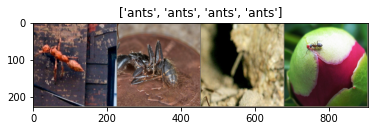

In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))

    # Using the mean and std of Imagenet is a common practice
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Training the model

Now, let’s write a general function to train a model. Here, we will illustrate:

* Scheduling the learning rate
* Saving the best model

In the following, parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler.

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict()) # store best model's weight
    best_acc = 0.0 # store best accuracy
 
    for epoch in range(num_epochs): # For every iteration through the whole dataset
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']: # First we will train the model then validate the model
            if phase == 'train': # If the model is on training phase,
                model.train() # Set model to training mode
            else: # Else if the model is on validation phase,
                model.eval() # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]: # iterate over the batch
                # Set both input and label to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients (clean the gradient for previous step)
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train': # if model is on training phase,
                scheduler.step() # step closer into the global optimum

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model prediction
Generic function to display predictions for a few images.

In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Finetuning the convnet
The Torchvision models [subpackage](https://pytorch.org/vision/stable/models.html) `torchvision.models` comprises numerous pre-trained models for us to use. This includes popular architectures such as ResNet-18, VGG16, GoogLeNet and ResNeXt-50. Now, we will load a pretrained model and reset final fully connected layer.

In [19]:
# Using pretrained model from resnet18 (https://pytorch.org/hub/pytorch_vision_resnet/)
model_ft = models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

# move the input and model to GPU for speed if available
model_ft = model_ft.to(device)

# useful when training a classification problem with C classes
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train and evaluate
It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [20]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.5803 Acc: 0.6762
val Loss: 0.2133 Acc: 0.9216
Epoch 1/24
train Loss: 0.5643 Acc: 0.7254
val Loss: 0.2414 Acc: 0.9020
Epoch 2/24
train Loss: 0.5162 Acc: 0.7951
val Loss: 0.5194 Acc: 0.8431
Epoch 3/24
train Loss: 0.5217 Acc: 0.8033
val Loss: 0.3729 Acc: 0.8758
Epoch 4/24
train Loss: 0.5750 Acc: 0.8033
val Loss: 0.2959 Acc: 0.8889
Epoch 5/24
train Loss: 0.4768 Acc: 0.8033
val Loss: 0.2304 Acc: 0.9150
Epoch 6/24
train Loss: 0.7533 Acc: 0.7172
val Loss: 0.3482 Acc: 0.8758
Epoch 7/24
train Loss: 0.4725 Acc: 0.8115
val Loss: 0.3254 Acc: 0.8758
Epoch 8/24
train Loss: 0.3486 Acc: 0.8607
val Loss: 0.2607 Acc: 0.9150
Epoch 9/24
train Loss: 0.3782 Acc: 0.8484
val Loss: 0.3041 Acc: 0.8889
Epoch 10/24
train Loss: 0.3097 Acc: 0.8607
val Loss: 0.2470 Acc: 0.9020
Epoch 11/24
train Loss: 0.2579 Acc: 0.8893
val Loss: 0.2423 Acc: 0.9150
Epoch 12/24
train Loss: 0.2775 Acc: 0.8893
val Loss: 0.2394 Acc: 0.9085
Epoch 13/24
train Loss: 0.2167 Acc: 0.9180
val Loss: 0.2686 Acc: 0.8954
Epoch 14/24
t

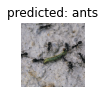

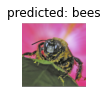

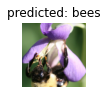

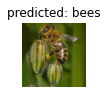

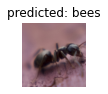

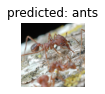

In [21]:
visualize_model(model_ft)

### ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

See [notes](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward) here.

In [22]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

In [23]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
train Loss: 0.6243 Acc: 0.7090
val Loss: 0.2724 Acc: 0.9150
Epoch 1/24
train Loss: 0.4517 Acc: 0.8156
val Loss: 0.2049 Acc: 0.9412
Epoch 2/24
train Loss: 0.6317 Acc: 0.6721
val Loss: 0.6346 Acc: 0.7778
Epoch 3/24
train Loss: 0.5608 Acc: 0.7664
val Loss: 0.1906 Acc: 0.9412
Epoch 4/24
train Loss: 0.3940 Acc: 0.8279
val Loss: 0.2024 Acc: 0.9281
Epoch 5/24
train Loss: 0.3958 Acc: 0.8320
val Loss: 0.2054 Acc: 0.9412
Epoch 6/24
train Loss: 0.5731 Acc: 0.7377
val Loss: 0.1849 Acc: 0.9346
Epoch 7/24
train Loss: 0.4171 Acc: 0.8197
val Loss: 0.2006 Acc: 0.9346
Epoch 8/24
train Loss: 0.3130 Acc: 0.8689
val Loss: 0.2143 Acc: 0.9281
Epoch 9/24
train Loss: 0.4365 Acc: 0.7951
val Loss: 0.2091 Acc: 0.9216
Epoch 10/24
train Loss: 0.3665 Acc: 0.8443
val Loss: 0.2229 Acc: 0.9281
Epoch 11/24
train Loss: 0.4283 Acc: 0.8238
val Loss: 0.2617 Acc: 0.9216
Epoch 12/24
train Loss: 0.3360 Acc: 0.8607
val Loss: 0.2502 Acc: 0.9216
Epoch 13/24
train Loss: 0.2921 Acc: 0.8852
val Loss: 0.2263 Acc: 0.9281
Ep

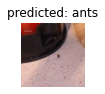

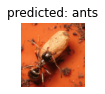

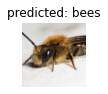

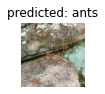

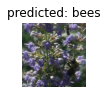

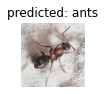

In [24]:
visualize_model(model_conv)
plt.show()